In [7]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# ────────────────────────────────────────────────────────────────────────────────
# 1) FIXED SETTINGS
# ────────────────────────────────────────────────────────────────────────────────
categories_map = {
    'Input 1': [1,2],
    'Input 2': list(range(1,6)),
    'Input 3': list(range(1,6)),
    'Input 4': list(range(1,22)),
    'Input 5': list(range(1,6)),
    'Input 6': [1,2,3],
    'Input 7': [1,2,3,4],
    'Input 8': list(range(1,11)),
}
all_inputs = [f'Input {i}' for i in range(1,19) if i!=12]
numeric_inputs = [f'Input {i}' for i in range(9,19) if i!=12]

# ────────────────────────────────────────────────────────────────────────────────
# 2) MLP BASE CLASS
# ────────────────────────────────────────────────────────────────────────────────
class MLP(nn.Module):
    def __init__(self, in_dim, layer_dims, activations):
        super().__init__()
        layers, dims = [], [in_dim] + layer_dims
        for i,h in enumerate(layer_dims):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            act = activations[i].lower()
            if act=='relu':     layers.append(nn.ReLU())
            elif act=='tanh':   layers.append(nn.Tanh())
            elif act=='sigmoid':layers.append(nn.Sigmoid())
            elif act=='softplus':layers.append(nn.Softplus())
            else: raise ValueError(f"Unknown act '{activations[i]}'")
        layers.append(nn.Linear(dims[-1],1))
        self.net = nn.Sequential(*layers)
    def forward(self,x):
        return self.net(x)

# ────────────────────────────────────────────────────────────────────────────────
# 3) CROSS-VALIDATION WITH LOSS OPTION & DETAILED ERRORS
# ────────────────────────────────────────────────────────────────────────────────
def cross_validate_mlp_with_history(
    df: pd.DataFrame,
    k_folds: int,
    layer_dims: list[int],
    activations: list[str],
    epochs: int,
    lr: float,
    batch_size: int,
    device: str,
    random_state: int,
    loss_type: str = 'mse'   # 'mse' or 'huber'
):
    # drop unused
    df = df.drop(columns=[c for c in ('F2','F3') if c in df.columns])

    # normalize target
    y_np = df['Output'].to_numpy(dtype=np.float32).reshape(-1,1)
    y_mean, y_std = y_np.mean(), (y_np.std() if y_np.std()!=0 else 1.0)
    y = (y_np - y_mean) / y_std

    # prepare features
    X = df[all_inputs].copy()
    # encode categoricals
    for col,cats in categories_map.items():
        if col not in X: continue
        if len(cats)==2:
            X[col] = X[col].map({cats[0]:+1.0, cats[1]:-1.0})
        else:
            X[col] = pd.Categorical(X[col],categories=cats)
            d = pd.get_dummies(X[col], prefix=col)
            for c in cats:
                nm = f"{col}_{c}"
                if nm not in d: d[nm]=0
            X = pd.concat([X.drop(columns=[col]), d], axis=1)

    # normalize numeric
    m, s = X[numeric_inputs].mean(), X[numeric_inputs].std().replace(0,1.0)
    X[numeric_inputs] = (X[numeric_inputs] - m) / s

    feature_names = X.columns.tolist()
    X_np = X.to_numpy(dtype=np.float32)

    # select loss
    if loss_type == 'mse':
        torch_loss_fn = nn.MSELoss()
    elif loss_type == 'huber':
        torch_loss_fn = nn.SmoothL1Loss()
    else:
        raise ValueError("loss_type must be 'mse' or 'huber'")

    # KFold
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=random_state)
    fold_results, histories, models = [], [], []

    for fold, (tr, va) in enumerate(kf.split(X_np), 1):
        X_tr, X_va = X_np[tr], X_np[va]
        y_tr, y_va = y[tr], y[va]

        # print indices
        print(f"Fold {fold} validation indices: {va.tolist()}")

        ds_tr = TensorDataset(torch.from_numpy(X_tr), torch.from_numpy(y_tr))
        ds_va = TensorDataset(torch.from_numpy(X_va), torch.from_numpy(y_va))
        ld_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=True)
        ld_va = DataLoader(ds_va, batch_size=batch_size)

        model = MLP(X_tr.shape[1], layer_dims, activations).to(device)
        opt = torch.optim.Adam(model.parameters(), lr=lr)

        tr_losses, va_losses, tr_r2s, va_r2s = [], [], [], []

        for epoch in range(1, epochs+1):
            model.train()
            for xb,yb in ld_tr:
                xb,yb = xb.to(device), yb.to(device)
                opt.zero_grad()
                torch_loss_fn(model(xb), yb).backward()
                opt.step()
            model.eval()
            with torch.no_grad():
                p_tr = model(torch.from_numpy(X_tr).to(device)).cpu().numpy().flatten()
                p_va = model(torch.from_numpy(X_va).to(device)).cpu().numpy().flatten()

            # compute epoch losses according to selected loss
            if loss_type == 'mse':
                tr_epoch = mean_squared_error(y_tr.flatten(), p_tr)
                va_epoch = mean_squared_error(y_va.flatten(), p_va)
            else:
                # huber per-sample then mean
                tr_epoch = torch_loss_fn(
                    torch.from_numpy(p_tr).unsqueeze(1),
                    torch.from_numpy(y_tr)
                ).item()
                va_epoch = torch_loss_fn(
                    torch.from_numpy(p_va).unsqueeze(1),
                    torch.from_numpy(y_va)
                ).item()

            tr_losses.append(tr_epoch)
            va_losses.append(va_epoch)
            tr_r2s.append(r2_score(y_tr.flatten(), p_tr))
            va_r2s.append(r2_score(y_va.flatten(), p_va))

        # detailed per-sample val errors
        val_errors = (p_va - y_va.flatten()).tolist()
        final = (tr_losses[-1], va_losses[-1])
        print(f"Validation errors (pred - true) per sample: {val_errors}")
        print(f"Final losses (train, val): {final}\n")

        fold_results.append({
            'fold': fold,
            'train_true': y_tr.flatten(),
            'train_pred': p_tr,
            'val_true':   y_va.flatten(),
            'val_pred':   p_va,
        })
        histories.append((tr_losses, va_losses, tr_r2s, va_r2s))
        models.append(model)

    norms = {'y_mean': y_mean, 'y_std': y_std, 'feat_mean': m.to_dict(), 'feat_std': s.to_dict()}
    return fold_results, histories, models, norms, feature_names


Fold 1 validation indices: [0, 4, 10, 11, 18, 36, 40, 45, 47, 66, 69, 70, 72, 81, 84, 100, 113]
Validation errors (pred - true) per sample: [-0.6363712549209595, 0.17580671608448029, 0.004827812314033508, 1.1949970722198486, 0.21209128201007843, 0.36394184827804565, -0.016837358474731445, -0.17830276489257812, 0.20197176933288574, 0.12644536793231964, -0.006391286849975586, -0.31403738260269165, 0.3688236474990845, 0.7166597843170166, 0.026593148708343506, -0.2870984673500061, 1.1075026988983154]
Final losses (train, val): (0.05802737921476364, 0.12172403186559677)

Fold 2 validation indices: [12, 15, 22, 26, 30, 31, 44, 53, 67, 78, 83, 93, 94, 105, 108, 109, 112]
Validation errors (pred - true) per sample: [0.008996844291687012, -0.335334837436676, 0.08970645070075989, 0.28111904859542847, 0.5227804780006409, -0.6218523979187012, -0.2293674349784851, 0.43783509731292725, -0.020927339792251587, 0.08110213279724121, 0.2052069902420044, -0.3350648283958435, -0.32384252548217773, 0.063295

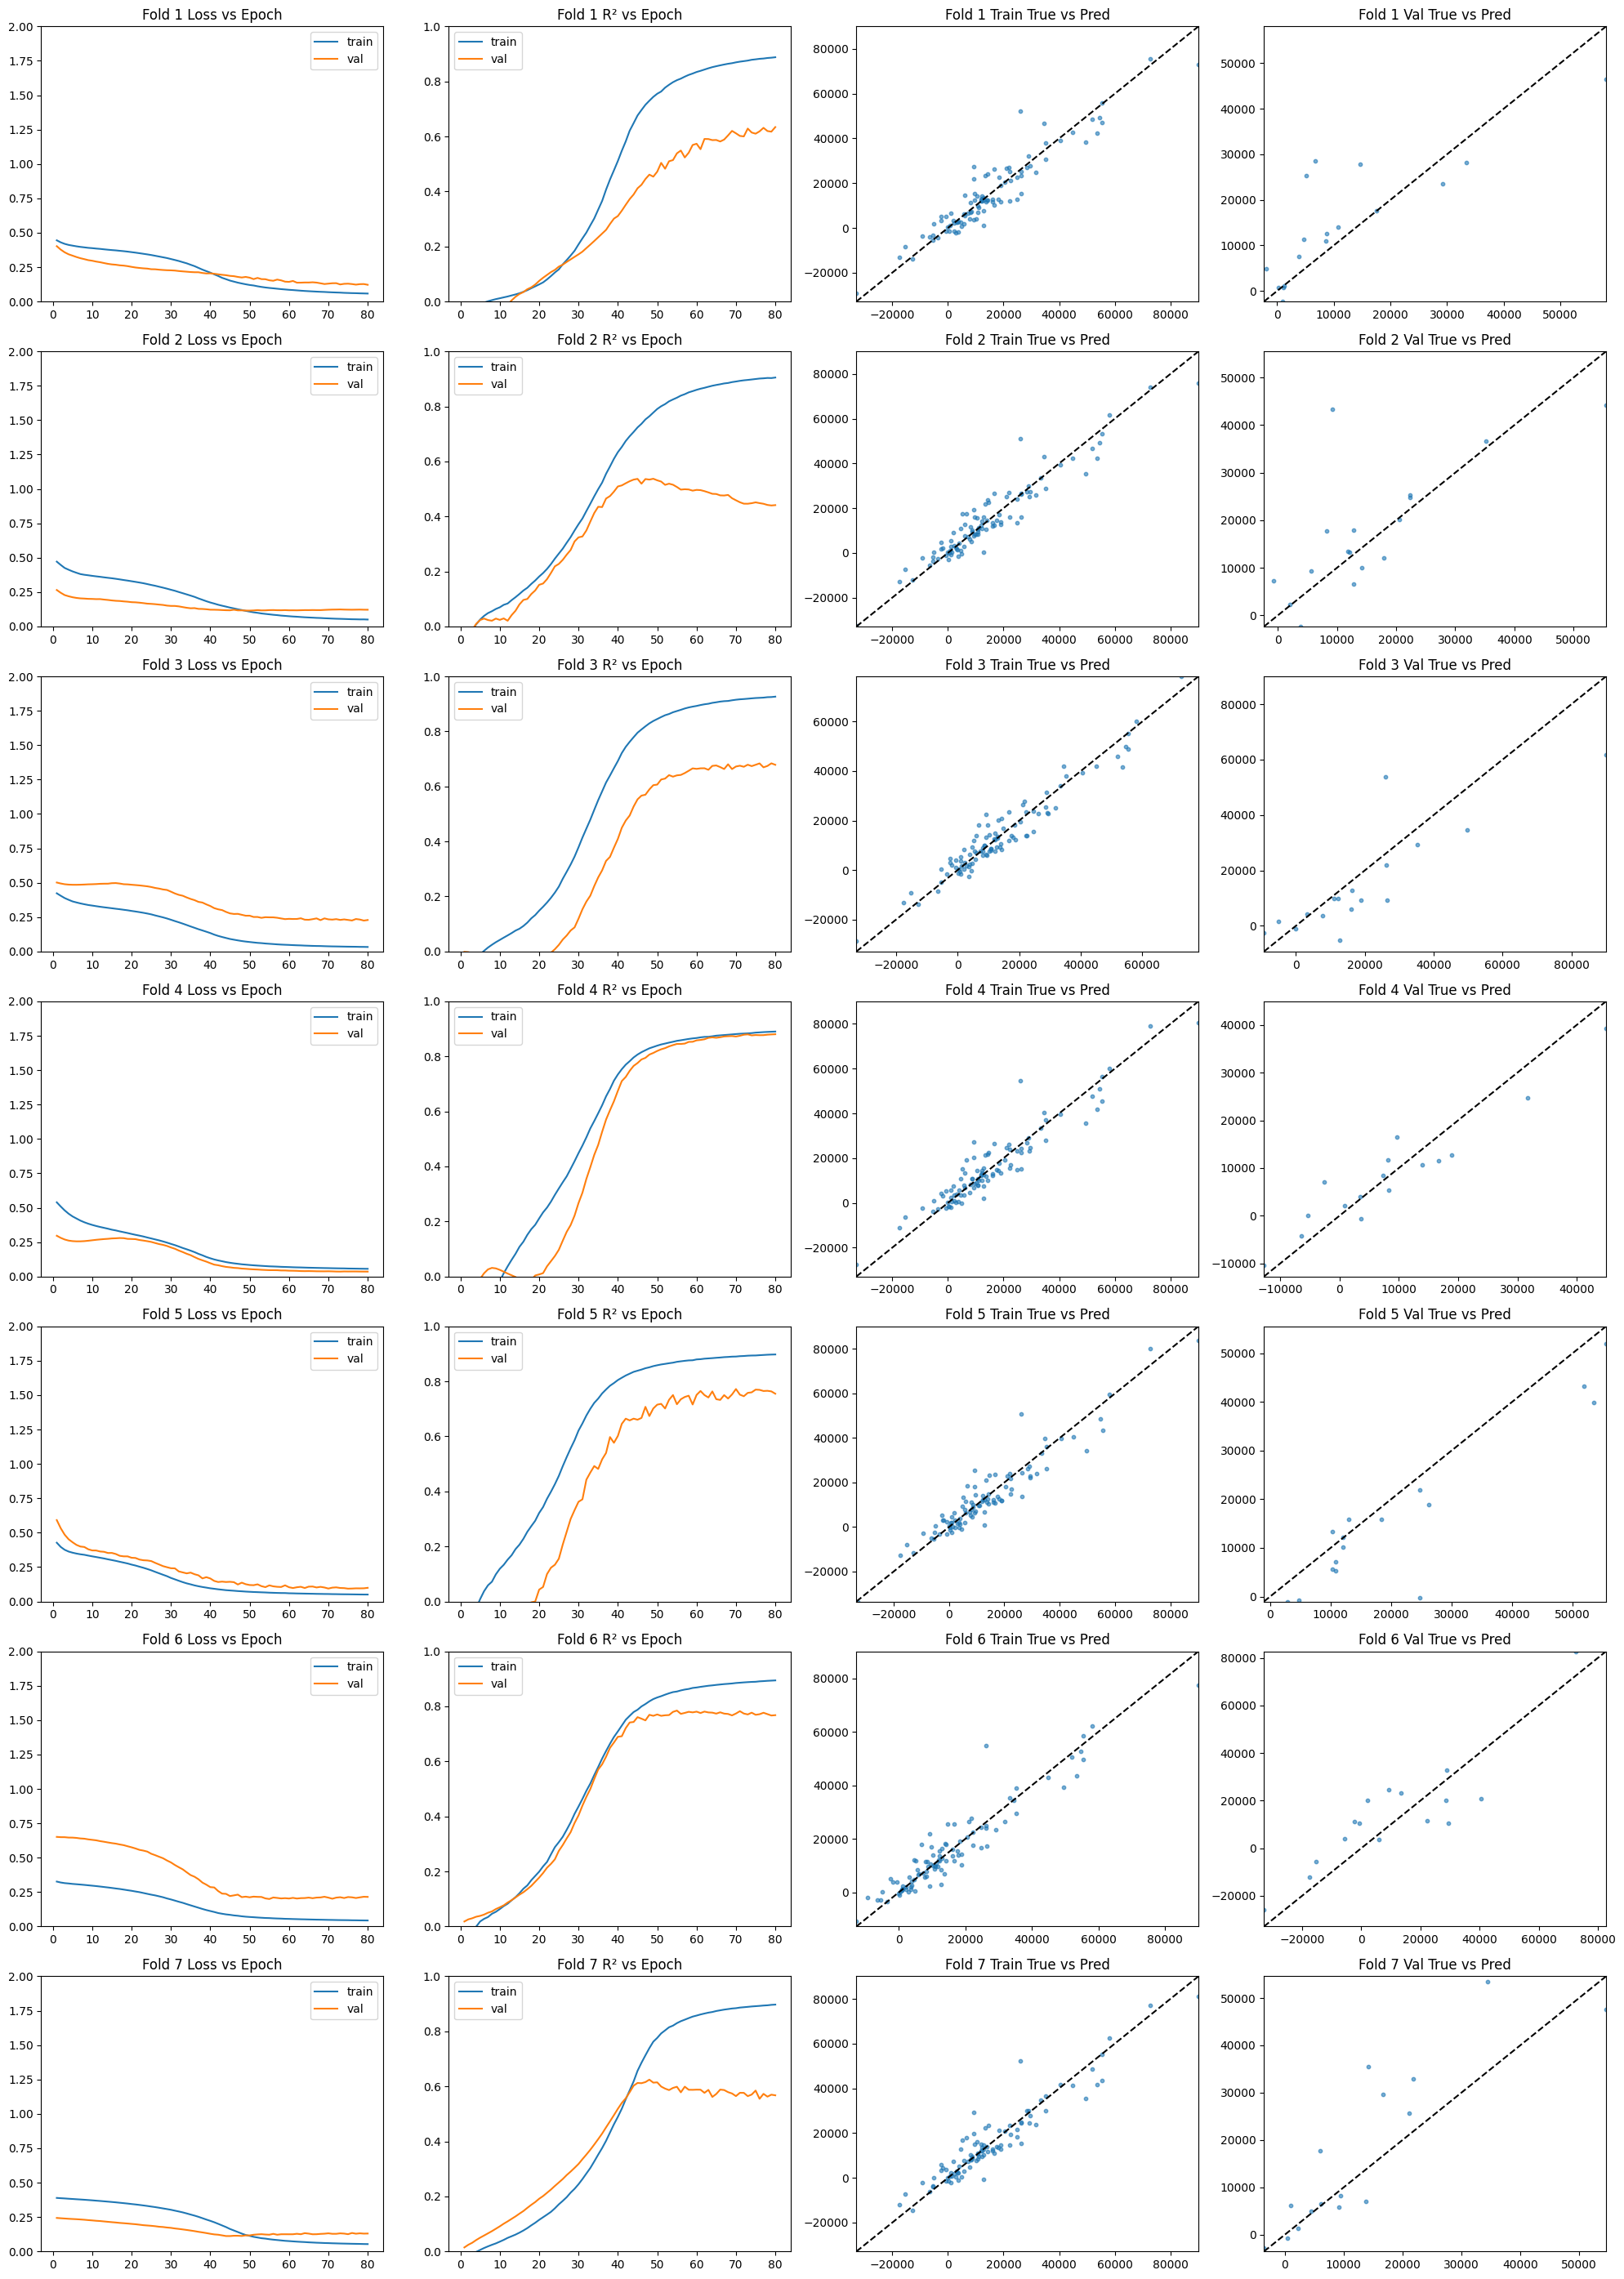

All outputs (models, hyperparams, norms, plot) saved in ./58c0fccc/


In [10]:
import os
import uuid
import json
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Assume cross_validate_mlp_with_history is already defined and imported
# It returns: folds, histories, models, norms, feature_names

if __name__ == '__main__':
    # Hyperparameters
    csv_path     = '/home/kamiar/chevron/Acid-neural-net/First Data-V3/data/train_val.csv'
    k_folds      = 7
    layer_dims   = [4, 4]
    activations  = ['softplus', 'softplus']
    epochs       = 80
    lr           = 1e-3
    batch_size   = 8
    random_state = 42
    loss_type    = 'huber'  # or 'mse'
    device       = 'cuda' if torch.cuda.is_available() else 'cpu'

    # 1) Load data
    df = pd.read_csv(csv_path)

    # 2) Run cross-validation
    folds, histories, models, norms, feature_names = cross_validate_mlp_with_history(
        df, k_folds,
        layer_dims, activations,
        epochs, lr, batch_size,
        device, random_state,
        loss_type=loss_type
    )

    # 3) Create a random tag folder
    tag = uuid.uuid4().hex[:8]
    os.makedirs(tag, exist_ok=True)

    # 4) Save each fold's model
    for i, model in enumerate(models, start=1):
        path = os.path.join(tag, f"{tag}_fold{i}.pth")
        torch.save(model.state_dict(), path)

    # 5) Save hyperparameters
    hyperparams = {
        "csv_path":     csv_path,
        "k_folds":      k_folds,
        "layer_dims":   layer_dims,
        "activations":  activations,
        "epochs":       epochs,
        "lr":           lr,
        "batch_size":   batch_size,
        "random_state": random_state,
        "loss_type":    loss_type
    }
    with open(os.path.join(tag, f"{tag}_hyperparams.json"), "w") as f:
        json.dump(hyperparams, f, indent=4)

    # 6) Save normalization constants
    # save norms with conversion
    safe_norms = {
        'y_mean':   float(norms['y_mean']),
        'y_std':    float(norms['y_std']),
        'feat_mean': {k: float(v) for k, v in norms['feat_mean'].items()},
        'feat_std':  {k: float(v) for k, v in norms['feat_std'].items()},
    }
    with open(os.path.join(tag, f"{tag}_norms.json"), "w") as f:
        json.dump(safe_norms, f, indent=4)

    # 7) Plot diagnostics for each fold
    fig, axes = plt.subplots(k_folds, 4, figsize=(20, 4*k_folds))
    for i, (fr, (tr_loss, va_loss, tr_r2, va_r2)) in enumerate(zip(folds, histories)):
        ax1, ax2, ax3, ax4 = axes[i]

        # a) Loss vs Epoch (train/val)
        ax1.plot(range(1, epochs+1), tr_loss, label='train')
        ax1.plot(range(1, epochs+1), va_loss, label='val')
        ax1.set_title(f'Fold {fr["fold"]} Loss vs Epoch')
        ax1.set_ylim(0, 2)
        ax1.legend()

        # b) R² vs Epoch
        ax2.plot(range(1, epochs+1), tr_r2, label='train')
        ax2.plot(range(1, epochs+1), va_r2, label='val')
        ax2.set_title(f'Fold {fr["fold"]} R² vs Epoch')
        ax2.set_ylim(0, 1)
        ax2.legend()

        # c) Train True vs Pred
        yt_tr = fr['train_true'] * norms['y_std'] + norms['y_mean']
        yp_tr = fr['train_pred'] * norms['y_std'] + norms['y_mean']
        ax3.scatter(yt_tr, yp_tr, s=10, alpha=0.6)
        lim = [min(yt_tr.min(), yp_tr.min()), max(yt_tr.max(), yp_tr.max())]
        ax3.plot(lim, lim, 'k--')
        ax3.set_xlim(lim); ax3.set_ylim(lim)
        ax3.set_title(f'Fold {fr["fold"]} Train True vs Pred')

        # d) Val True vs Pred
        yt_va = fr['val_true'] * norms['y_std'] + norms['y_mean']
        yp_va = fr['val_pred'] * norms['y_std'] + norms['y_mean']
        ax4.scatter(yt_va, yp_va, s=10, alpha=0.6)
        lim = [min(yt_va.min(), yp_va.min()), max(yt_va.max(), yp_va.max())]
        ax4.plot(lim, lim, 'k--')
        ax4.set_xlim(lim); ax4.set_ylim(lim)
        ax4.set_title(f'Fold {fr["fold"]} Val True vs Pred')

    plt.tight_layout()
    # 8) Save diagnostics plot
    fig.savefig(os.path.join(tag, f"{tag}_diagnostics.png"))
    plt.show()

    print(f"All outputs (models, hyperparams, norms, plot) saved in ./{tag}/")
